# Introduction

This projected was conducted by Pierre Bourdon & Eike Wefelnberg. After briefly analysing the daily returns on the S&P500 with respect to stylized facts of asset returns, we built an artificial recurrent neural network (RNN) using the Long short-term memory (LSTM) architecture. The intention was to employ daily time-series data on the LSTM model in order to predict the level of the S&P500. Finally, we compared the predictive power of the LSTM model with the performance of a more commonly employed deep neural network (DNN). 

Disclaimer: This project is for practice purposes only and does not intend to give any recommendation on trading strategies or forecasts. 

# Importing & Preparing Data

The data was downloaded from the Center for Research in Security Prices (CRSP) (http://crsp.org/). 

In [1]:
from google.colab import files
uploaded = files.upload()

Saving sp.csv to sp (1).csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import io
df = pd.read_csv(io.BytesIO(uploaded['sp.csv'])) 
df = df.sort_values(by = 'DATE')
df['lnret'] = np.log(1+df['sprtrn'])
df['sqlnret'] = df['lnret']**2
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,DATE,sprtrn,spindx,lnret,sqlnret
0,19630102,-0.006498,62.69,-0.006519,4.250002e-05
1,19630103,0.016430,63.72,0.016296,2.655755e-04
2,19630104,0.006434,64.13,0.006413,4.113157e-05
3,19630107,-0.000156,64.12,-0.000156,2.433980e-08
4,19630108,0.009669,64.74,0.009623,9.259355e-05


# Exploratory Data Analysis

Let's calculate log returns as they are assumed to better fit normality assumption.

In [0]:
#Calculate log returns
df['lnret'] = np.log(1+df['sprtrn'])

Let's check the normality assumption by conducting a Jarque-Bera Test. We will test the null hypothesis that daily returns are normally distributed. 

In [4]:
stats.jarque_bera(df['lnret'])

(435247.0031345941, 0.0)

With a p-value of close to 0 and a test statistic of 435,247, we can clearly reject the null hypothesis.
This suggests that daily log returns are not normally distributed. 

Let's figure out where the abnormality comes from:

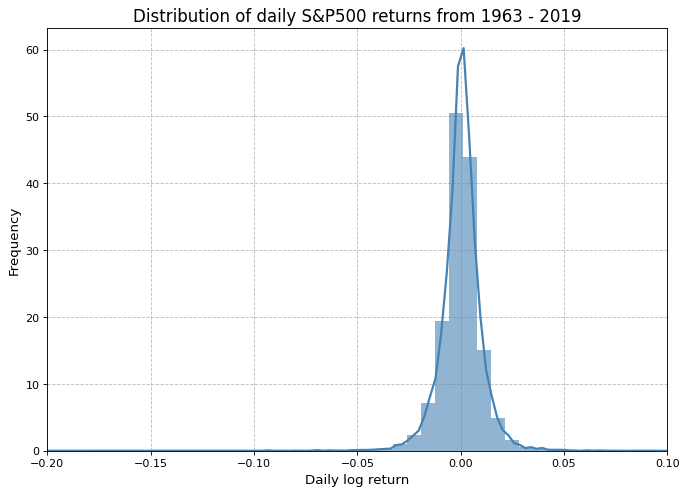

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(df['lnret'], label='daily log returns', color = 'steelblue', **kwargs)
plt.xlim(-0.2,0.1)
plt.title('Distribution of daily S&P500 returns from 1963 - 2019', fontsize = 15)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.xlabel('Daily log return', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

In [6]:
stats.kurtosis(df['lnret'])

26.906224601408255

[Scipy.stats.kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) calculates Fisher's definition of kurtosis by default. Thus, 3 (the kurtosis of a normal distribution) is subtracted from the result and the 26.90 is considered excess kurtosis. Consequently, we can observe that the distribution is leptokurtic, i.e. has fat tails, and the probability for the occurence of extreme outliers is larger than in a normal distribution.

In [7]:
stats.skew(df['lnret'])

-1.0119023518563397

As expected, we get a negtative skewness coefficient depicting that the daily log returns are negatively skewed. 

The leptokurtic negatively skewed distribution of returns is actually in line with the so called **stylized facts of asset returns** (Cont 2001).

## Volatiltiy Clustering

A lot of empirical evidence has been provided on **volatility clustering**. This means that large variations in prices (e.g. in times of macroeconomic uncertainties) are likely followed by repeated heavy price variations. Let's visualise, whether we can find evidence for this phenomenon in the S&P500. 

In [0]:
#Calculate squared log returns
df['sqlnret'] = df['lnret']**2

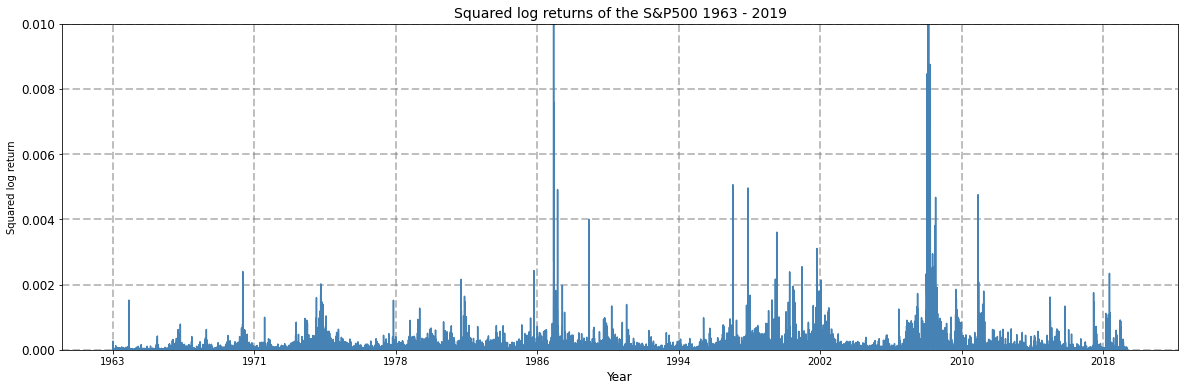

In [9]:
%matplotlib inline
df['YEAR'] = df['DATE'].astype(str)
df['YEAR']= df['YEAR'].str.slice(0, 4, 1)
df = df.set_index('YEAR')
fig = df.sqlnret.plot(figsize = (20,6), color = 'steelblue')
plt.yticks(fontsize = 12)
plt.ylim(0,0.01)
plt.ylabel('Squared log return', fontsize = 10)
plt.xticks(fontsize = 10)
plt.xlabel ('Year', fontsize = 12)
plt.title('Squared log returns of the S&P500 1963 - 2019', fontsize = 14)
df = df.reset_index()
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--', linewidth=2)
plt.show()

We can clearly see volatility clustering in times of financial macroeconomic uncertainties (global financial crisis, dot-com bubble, etc.). Therefore, we can conclude that the log returns are not independent and identically distributed. This is a major assumption for the random walk model, which is why our findings support the hypothesis that S&P500’s log returns do not follow a random walk.

## Autocorrelations of returns

This idea can further be analysed when looking at the autocorrelation of squared log returns. The autocorrelation depicts how strongly a signal correlates with a delayed (or lagged) copy of itself. 

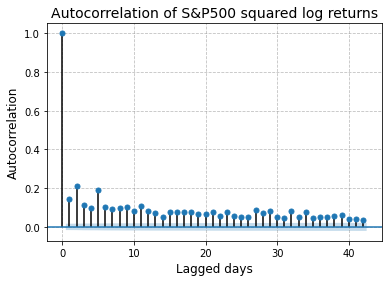

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['sqlnret'])
plt.title('Autocorrelation of S&P500 squared log returns', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Lagged days', fontsize = 12)
plt.xticks(fontsize = 10)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')

Let's plot the autocorrelation of the level of the S&P500:

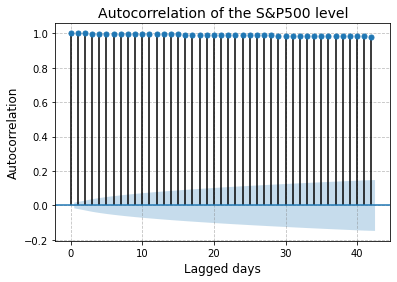

In [11]:
plot_acf(df['spindx'])
plt.title('Autocorrelation of the S&P500 level', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Lagged days', fontsize = 12)
plt.xticks(fontsize = 10)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')

As expected, the lagged level of the S&P500 has significant predictive power on the current level. Of course, this is far from surprising. 

# Building the deep neural networks

### Importing packages

In [0]:
import tensorflow
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

## LSTM

### Splitting, normalizing and preparing the time-series data 

In [0]:
#Splitting the data into train and test
data = df['spindx'].to_numpy()
data = data.reshape(-1,1)
data_train = data[:int(0.85*(len(df)))]
data_test = data[int(0.85*(len(df))):]

In [0]:
#Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)

In [0]:
#building time series 
batch_size = 1
features = 1
time_steps = 10
num_steps_train = len(train_scaled) - time_steps
X_train = np.zeros([num_steps_train, time_steps, features])
y_train = np.zeros(num_steps_train)
for step in range(num_steps_train):
  X_train[step, :time_steps] = train_scaled[step:step + time_steps]
  y_train[step] = train_scaled[step + time_steps]

num_steps_test = len(test_scaled) - time_steps
X_test = np.zeros([num_steps_test, time_steps, features])
y_test = np.zeros(num_steps_test)
for step in range(num_steps_test):  
  X_test[step, :time_steps] = test_scaled[step:step + time_steps]
  y_test[step] = test_scaled[step + time_steps]


### Building & Training the LSTM Model

In [16]:
#Hyperparameters
dropout = 0.2
epochs = 10
batch_size = 64
optimizer = Adam()

#Building the model
model = Sequential()
model.add(LSTM(128, input_shape = X_train.shape[1:],return_sequences= True ))
model.add(Dropout(dropout))
model.add(LSTM(64))
model.add(Dropout(dropout))
model.add(Dense(64,activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(32,activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
 
#Training the model
history_LSTM = model.fit(X_train, y_train, epochs=epochs, 
                         batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 6s 32ms/step - loss: 0.0833 - val_loss: 0.8209
Epoch 2/10
191/191 [==============================] - 5s 29ms/step - loss: 0.0357 - val_loss: 0.6576
Epoch 3/10
191/191 [==============================] - 5s 29ms/step - loss: 0.0330 - val_loss: 0.6855
Epoch 4/10
191/191 [==============================] - 6s 29ms/step - loss: 0.0285 - val_loss: 0.2563
Epoch 5/10
191/191 [==============================] - 6s 29ms/step - loss: 0.0273 - val_loss: 0.1226
Epoch 6/10
191/191 [==============================] - 6s 29ms/step - loss: 0.0268 - val_loss: 0.0956
Epoch 7/10
191/191 [==============================] - 6s 29ms/step - loss: 0.0253 - val_loss: 0.1836
Epoch 8/10
191/191 [==============================] - 6s 29ms/step - loss: 0.0253 - val_loss: 0.3361
Epoch 9/10
191/191 [==============================] - 6s 29ms/step - loss: 0.0249 - val_loss: 0.0392
Epoch 10/10
191/191 [==============================] - 5s 28ms/step - loss: 0.0247 - val_lo

### Evaluating the LSTM model

In [0]:
#Predicting
y_pred = model.predict(X_test)

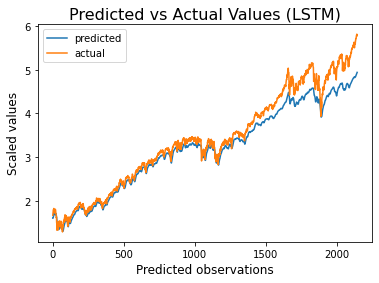

In [18]:
#Plotting the results
plt.plot(y_pred, label = 'predicted')
plt.plot(y_test, label = 'actual')
plt.title('Predicted vs Actual Values (LSTM)', fontsize = 16)
plt.ylabel('Scaled values', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Predicted observations', fontsize = 12)
plt.xticks(fontsize = 10)
plt.legend()
plt.show()

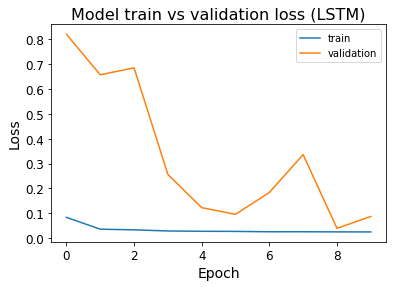

In [19]:
#Plotting the loss function
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Model train & validation loss (LSTM)', fontsize = 16)
plt.ylabel('Loss', fontsize = 14)
plt.yticks(fontsize = 12)
plt.xlabel('Epoch', fontsize = 14)
plt.xticks(fontsize = 12)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Regular deep neural network

### Preparing and splitting the time series data

In [0]:
time_steps = 10
num_steps_train = len(train_scaled) - time_steps
X_train = np.zeros([num_steps_train, time_steps])
y_train = np.zeros(num_steps_train)
for step in range(num_steps_train):
  X_train[step, :time_steps] = train_scaled[step:step + time_steps,0]
  y_train[step] = train_scaled[step + time_steps]

num_steps_test = len(test_scaled) - time_steps
X_test = np.zeros([num_steps_test, time_steps])
y_test = np.zeros(num_steps_test)
for step in range(num_steps_test):  
  X_test[step, :time_steps] = test_scaled[step:step + time_steps,0]
  y_test[step] = test_scaled[step + time_steps]

### Building & Training the DNN 

In [83]:
#Hyperparameters
dropout = 0.5
epochs = 40
batch_size = 32
optimizer = Adam()

#Building the model
model_DNN = Sequential()
model_DNN.add(Dense(128,activation='relu', input_shape = X_train.shape[1:]))
model_DNN.add(Dropout(dropout))
model_DNN.add(Dense(64,activation='relu'))
model_DNN.add(Dropout(dropout))
model_DNN.add(Dense(32,activation='relu'))
model_DNN.add(Dropout(dropout))
model_DNN.add(Dense(1))
model_DNN.compile(loss='mean_squared_error', 
                   optimizer=optimizer)

#Training the model
history_DNN = model_DNN.fit(X_train, y_train, epochs=epochs, 
                            batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/40
381/381 [==============================] - 1s 2ms/step - loss: 0.2554 - val_loss: 1.7153
Epoch 2/40
381/381 [==============================] - 1s 2ms/step - loss: 0.1376 - val_loss: 1.2446
Epoch 3/40
381/381 [==============================] - 1s 2ms/step - loss: 0.1133 - val_loss: 1.2101
Epoch 4/40
381/381 [==============================] - 1s 2ms/step - loss: 0.1056 - val_loss: 1.3977
Epoch 5/40
381/381 [==============================] - 1s 2ms/step - loss: 0.1023 - val_loss: 1.0289
Epoch 6/40
381/381 [==============================] - 1s 2ms/step - loss: 0.0969 - val_loss: 1.2288
Epoch 7/40
381/381 [==============================] - 1s 2ms/step - loss: 0.0928 - val_loss: 0.6430
Epoch 8/40
381/381 [==============================] - 1s 2ms/step - loss: 0.0898 - val_loss: 0.4669
Epoch 9/40
381/381 [==============================] - 1s 2ms/step - loss: 0.0931 - val_loss: 0.9421
Epoch 10/40
381/381 [==============================] - 1s 2ms/step - loss: 0.0867 - val_loss: 0.5814

### Evaluating the DNN 

In [0]:
#Predicting
y_pred_DNN = model_DNN.predict(X_test)

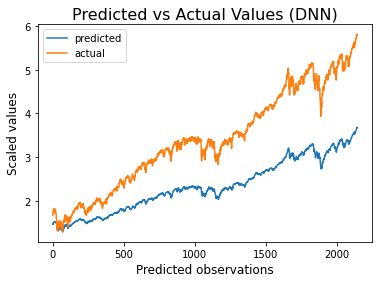

In [85]:
#Plotting the results
plt.plot(y_pred_DNN, label = 'predicted')
plt.plot(y_test, label = 'actual')
plt.title('Predicted vs Actual Values (DNN)', fontsize = 16)
plt.ylabel('Scaled values', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Predicted observations', fontsize = 12)
plt.xticks(fontsize = 10)
plt.legend()
plt.show()

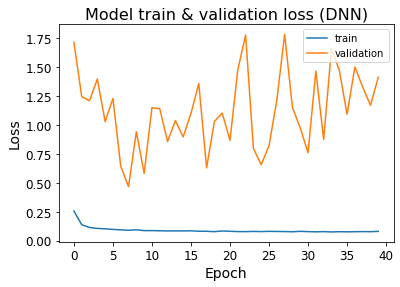

In [86]:
#Plotting the loss function
plt.plot(history_DNN.history['loss'])
plt.plot(history_DNN.history['val_loss'])
plt.title('Model train & validation loss (DNN)', fontsize = 16)
plt.ylabel('Loss', fontsize = 14)
plt.yticks(fontsize = 12)
plt.xlabel('Epoch', fontsize = 14)
plt.xticks(fontsize = 12)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Further improvements

All in all, one has to note that the purpose of this projected was to get hands on experience on recurrent neural networks (LSTM's in particular) and their application on time-series data. Thus, there exists a long list of possible improvements for the future. Some of which, we have noted down here:
*   *More (time-series) data/ features*: This might include the constitutent equities of the S&P500, futures, the risk-free rate (US government bonds), corporate bonds, inflation, etc.
*   *More computing power*: This would also require the employment of a GPU (rather than the CPU of our personal computers) 
*   *Hyperparameter search*: With more computing power available, a hyperparameter search can be deployed to find the best parameters for the LSTM model. 


# References

Cont, R.(2001). Empirical properties of asset returns: stylized facts and statistical issues. 
Quantitative Finance, 1, 223-236. http://finance.martinsewell.com/stylized-facts/dependence/Cont2001.pdf

&copy; Pierre Bourdon & Eike Wefelnberg